In [0]:
%restart_python 


===== XGBoost Model Accuracy =====
RMSE : 3.53
MAE  : 2.43
MAPE : 9.09%


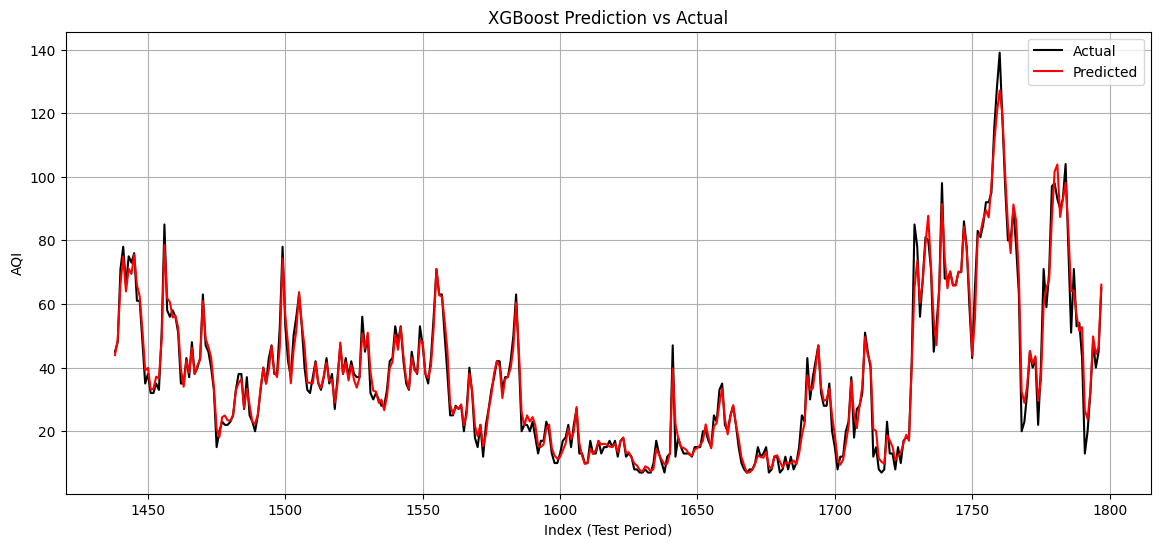

[66.08156]


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# -----------------------------------------
# 1. LOAD DATA
# -----------------------------------------
# df = pd.read_csv("your_file.csv")
df_spark = spark.read.table("aqi_cat.silver_schema.hyderabad_aqi_dataset").select("date","aqi_pm25")
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df= df_spark.toPandas()

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Choose target
target = "aqi_pm25"   # or "pm25"

# -----------------------------------------
# 2. FEATURE ENGINEERING
# -----------------------------------------

# Create lag features (AQI/PM2.5 from previous days)
df['lag1']  = df[target].shift(1)
df['lag2']  = df[target].shift(2)
df['lag7']  = df[target].shift(7)
df['lag14'] = df[target].shift(14)

# Rolling mean features
df['roll3']  = df[target].rolling(3).mean()
df['roll7']  = df[target].rolling(7).mean()
df['roll30'] = df[target].rolling(30).mean()

# Date features
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.dayofweek

# Drop rows with NaN (from lags)
df2 = df.dropna().reset_index(drop=True)

# -----------------------------------------
# 3. TRAIN-TEST SPLIT
# -----------------------------------------
X = df2.drop([target, 'date'], axis=1)
y = df2[target]

# 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -----------------------------------------
# 4. TRAIN XGBOOST MODEL
# -----------------------------------------
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model.fit(X_train, y_train)

# -----------------------------------------
# 5. PREDICT
# -----------------------------------------
y_pred = model.predict(X_test)

# -----------------------------------------
# 6. ACCURACY METRICS
# -----------------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n===== XGBoost Model Accuracy =====")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

# -----------------------------------------
# 7. PLOT RESULTS
# -----------------------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label="Actual", color='black')
plt.plot(y_test.index, y_pred, label="Predicted", color='red')

plt.title("XGBoost Prediction vs Actual")
plt.xlabel("Index (Test Period)")
plt.ylabel("AQI" if target=="aqi_pm25" else "PM2.5")
plt.legend()
plt.grid(True)
plt.show()

last_row = X_test.tail(1).copy()
future_preds = model.predict(last_row)


# for i in range(30):  # next 30 days
#     next_pred = model.predict(last_row)[0]
#     future_preds.append(next_pred)
#     # update lags + rolling windows with this new prediction
#     # (I will generate full code if you want 7/30/60-day forecasting)

print(future_preds)


        param1      param2      param3  true_label  predicted
193  55.718770  103.384964   71.677697           0          0
194  53.163909  122.706929   76.454930           0          0
195  51.241103   95.406391   68.201245           0          0
196  54.151679   91.439162   75.572530           0          0
197  47.611713  104.789798   77.669297           0          0
198  55.187700   94.899836   72.841001           0          0
199  45.106181   95.557067   78.018404           0          0
200  90.000000  150.000000  200.000000           1          1
201  10.000000   50.000000    5.000000           1          1
202  70.000000   30.000000  150.000000           1          1


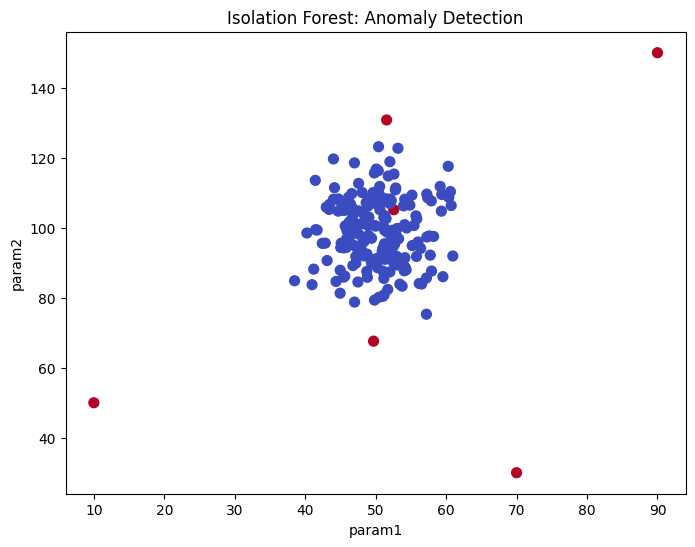

In [0]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate normal readings for 3 parameters
normal_data = np.random.normal(loc=[50, 100, 75], scale=[5, 10, 8], size=(200, 3))

# Generate some anomalous readings
anomalies = np.array([
    [90, 150, 200],   # extreme anomaly
    [10, 50, 5],
    [70, 30, 150]
])

# Combine into one dataset
X = np.vstack([normal_data, anomalies])

# Convert to DataFrame for better visualization
df = pd.DataFrame(X, columns=["param1", "param2", "param3"])
df["true_label"] = [0]*200 + [1]*3  # 0=normal, 1=anomaly
df.head()

# Create Isolation Forest
clf = IsolationForest(contamination=0.025, random_state=42)
clf.fit(X)

# Predict anomalies
df['predicted'] = clf.predict(X)
# Convert to 0/1: -1 = anomaly, 1 = normal
df['predicted'] = df['predicted'].apply(lambda x: 0 if x == 1 else 1)

print(df.tail(10))  # check last 10 rows, anomalies should be detected

plt.figure(figsize=(8,6))
plt.scatter(df['param1'], df['param2'], c=df['predicted'], cmap='coolwarm', s=50)
plt.xlabel('param1')
plt.ylabel('param2')
plt.title('Isolation Forest: Anomaly Detection')
plt.show()


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Features: [Size (1000 sq.ft), Number of rooms]
X = np.array([
    [1.0, 2],
    [1.5, 3],
    [2.0, 3],
    [2.5, 4],
    [3.0, 5]
])

# Target: Price (in lakhs)
y = np.array([40, 55, 65, 80, 95])

# Fit model
model = LinearRegression()
model.fit(X, y)

print("Coefficients (weights):", model.coef_)
print("Intercept (bias):", model.intercept_)



Coefficients (weights): [20.  5.]
Intercept (bias): 9.999999999999986


In [0]:
X_new = np.array([[2.2, 4]])
y_pred = model.predict(X_new)
print("Predicted price:", y_pred[0])


Predicted price: 74.0


In [0]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_all = model.predict(X)
print("MSE:", mean_squared_error(y, y_pred_all))
print("R² Score:", r2_score(y, y_pred_all))


MSE: 2.0194839173657903e-29
R² Score: 1.0


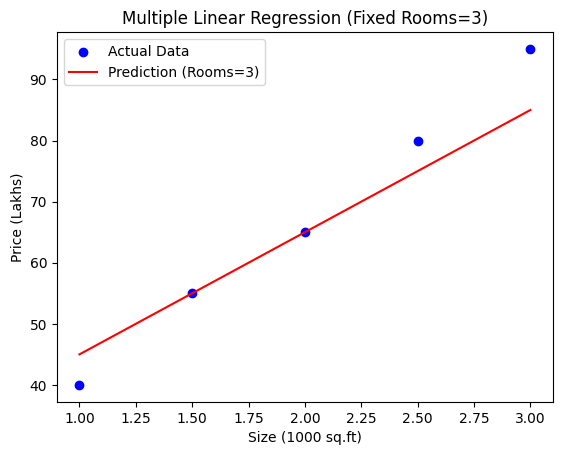

In [0]:
sizes = np.linspace(1, 3, 10).reshape(-1, 1)
rooms = np.full_like(sizes, 3)
X_plot = np.hstack([sizes, rooms])
y_plot = model.predict(X_plot)

plt.scatter(X[:, 0], y, color='blue', label='Actual Data')
plt.plot(sizes, y_plot, color='red', label='Prediction (Rooms=3)')
plt.xlabel("Size (1000 sq.ft)")
plt.ylabel("Price (Lakhs)")
plt.title("Multiple Linear Regression (Fixed Rooms=3)")
plt.legend()
plt.show()


In [0]:
from sklearn.model_selection import train_test_split

# Example data
X = [[1.0, 2], [1.5, 3], [2.0, 3], [2.5, 4], [3.0, 5]]
y = [40, 55, 65, 80, 95]

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train)
print("y_train:", y_train)
print("X_test:", X_test)
print("y_test:", y_test)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff689e629080>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


X_train: [[3.0, 5], [2.0, 3], [1.0, 2], [2.5, 4]]
y_train: [95, 65, 40, 80]
X_test: [[1.5, 3]]
y_test: [55]


In [0]:
from sklearn.preprocessing import StandardScaler

X = [[1, 200],
     [2, 300],
     [3, 400]]

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
print(X_std)

[[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xffed94520040>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


Accuracy: 0.9736842105263158

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96        43
           1       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



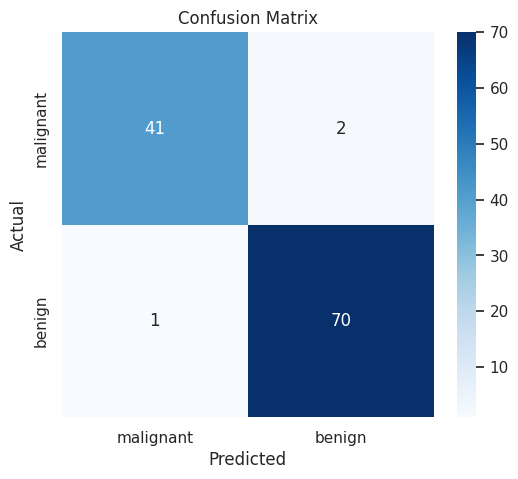

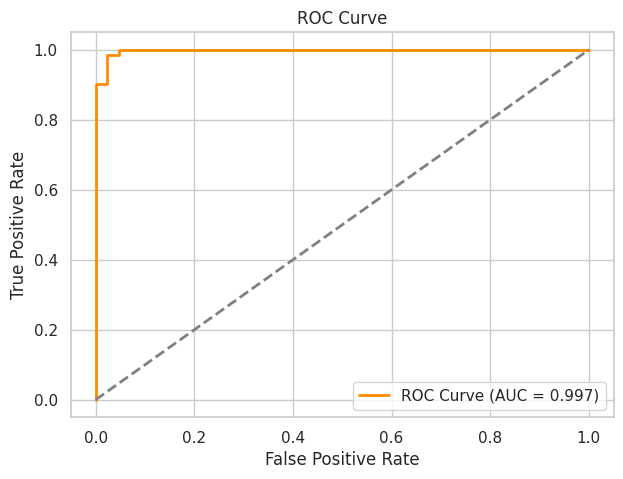

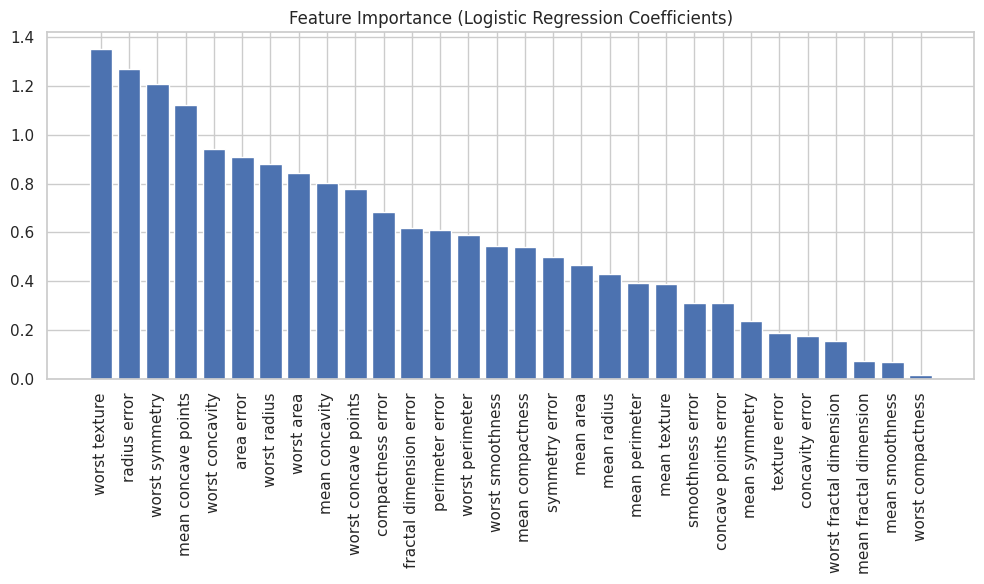

In [0]:
# Logistic Regression + Visualizations
# ------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    accuracy_score
)

sns.set(style="whitegrid")

# 1. Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 5. Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 6. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# --------------------------
# 📌 Visualization Section
# --------------------------

# 1️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# 2️⃣ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC Curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# 3️⃣ Feature Importance (absolute coefficient values)
importance = np.abs(model.coef_[0])
sorted_idx = np.argsort(importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance[sorted_idx])
plt.xticks(range(len(importance)),
           np.array(data.feature_names)[sorted_idx],
           rotation=90)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.tight_layout()
plt.show()
